# NODDI-Watson in crossings using MIX optimization

Estimation of microstructure parameters in crossing tissue configuration is currently still a challenge in microstructure imaging. To tackle this problem, *(Farooq et al. 2016)* proposed a stochastic optimization approach called MIX to fit known microstructure models such as NODDI-Watson *(Zhang et al. 2012)* in crossings, which they refer to NODDIx. In this example, we use MIX to reproduce their example application of NODDIx, whose configuration simply an extension of regular NODDI-Watson with multiple bundles: 

\begin{align}
 E^{\textrm{NODDIx
}}_{\textrm{Watson}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot|\lambda_{\textrm{CSF}})}^{\textrm{Ball}}}_{\textrm{CSF}}
                             +\sum_{i=1}^{2}\overbrace{W(\kappa_i,\boldsymbol{\mu}_i)}^{\textrm{Watson}}\,*_{\mathbb{S}^2}\, \left[\underbrace{f_{h,i}\overbrace{E_{\textrm{h}}(\cdot|\lambda_\perp^{\textrm{tort}},\lambda_\parallel)}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}+\underbrace{f_{r,i}\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}\right].
\end{align}

MIX addresses the issue of robustly finding a global minimum for models with many parameters. The approach involves taking multiple optimization steps, which separately optimize the linear parameters (volume fractions) and non-linear parameters (all the others).

## Generate NODDIx model

We generate the model the same way as in the previous example - only now we include two instead of one Watson-dispersed bundles. First we import the separate pieces:

In [1]:
from dmipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()

Combine them into one Watson dispersed bundle and set NODDI's parameter links and fixes:

In [2]:
from dmipy.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle1 = SD1WatsonDistributed(models=[stick, zeppelin])
watson_dispersed_bundle1.parameter_names

['G2Zeppelin_1_lambda_perp',
 'SD1Watson_1_odi',
 'G2Zeppelin_1_lambda_par',
 'SD1Watson_1_mu',
 'C1Stick_1_lambda_par',
 'partial_volume_0']

In [3]:
watson_dispersed_bundle1.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle1.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
watson_dispersed_bundle1.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)

We can create a second instance of the first bundle by using the .copy() function.

In [4]:
watson_dispersed_bundle2 = watson_dispersed_bundle1.copy()

In [5]:
from dmipy.core.modeling_framework import MultiCompartmentModel
NODDIx_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle1, watson_dispersed_bundle2])

As the last step we fix the isotropic diffusivity of the model

In [6]:
NODDIx_mod.parameter_names

['G1Ball_1_lambda_iso',
 'SD1WatsonDistributed_1_partial_volume_0',
 'SD1WatsonDistributed_1_SD1Watson_1_mu',
 'SD1WatsonDistributed_2_SD1Watson_1_odi',
 'SD1WatsonDistributed_2_partial_volume_0',
 'SD1WatsonDistributed_2_SD1Watson_1_mu',
 'SD1WatsonDistributed_1_SD1Watson_1_odi',
 'partial_volume_0',
 'partial_volume_1',
 'partial_volume_2']

In [7]:
NODDIx_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

## Human Connectome Project Example 

In [8]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()
sub_image = data_hcp[70:90,: , 70:90]

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


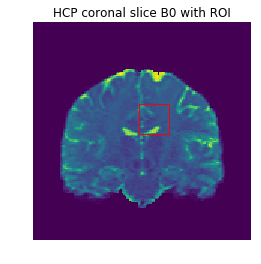

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

## Fit NODDIx to the HCP subsection

To use MIX instead of the standard Brute2Fine the solver needs to set to 'mix'. The option 'maxiter' states the threshold amount of iterations the stochastic algorithms takes.

#### Note: Fitting NODDIx using MIX even on this small patch takes close to 90 minutes!

In [16]:
NODDIx_fit = NODDIx_mod.fit(scheme_hcp, sub_image, solver='mix', maxiter=300)

Using parallel processing with 8 workers.
Setup MIX optimizer in 3.2901763916e-05 seconds
Fitting of 400 voxels complete in 5606.92030287 seconds.
Average of 14.0173007572 seconds per voxel.


## Visualizing NODDIx FODs

We can now visualize the FODs of the fitted NODDIx model near the corpus callosum and centrum semiovale. We expect to find a single-bundle moving in from the left, leading to a crossing area on the right.

In [22]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724').subdivide()
fods = NODDIx_fit.fod(sphere.vertices, visual_odi_lower_bound=0.05)

In [27]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

volume_res = fitted_parameters['partial_volume_0']
volume_im = slicer(volume_res[:, 0, :, None], interpolation='nearest', affine=affine, opacity=0.7)

In [28]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, volume_im)
fvtk.record(ren=ren, size=[700, 700])

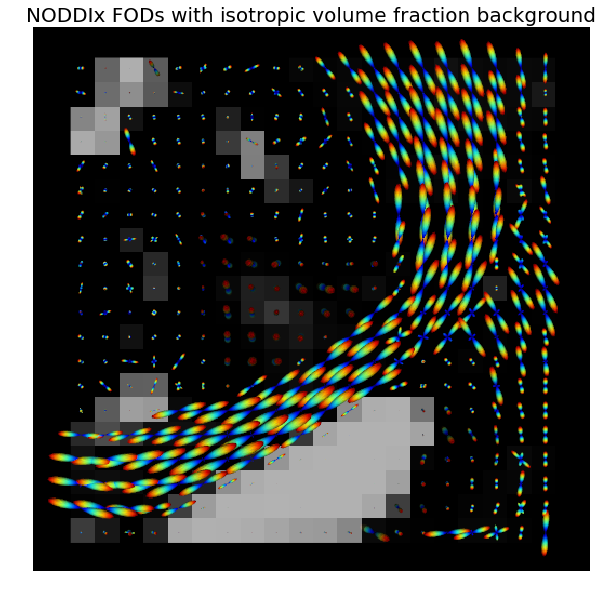

In [32]:
import matplotlib.image as mpimg
img = mpimg.imread('dipy.png')

plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.title('NODDIx FODs with isotropic volume fraction background', fontsize=20)
plt.axis('off');

Indeed, MIX managed to estimate a smooth FOD map, finding consistent crossing areas on the right and a smooth bundle continuation out of the corpus callosum - which is impressive. However, from the background we can see that the isotropic compartment is underestimated above the corpus callosum.

## Visualizing parameters maps

Visualizing the estimated parameter maps as before we can see they are much less interpretable than those of simpler single bundle models. Only partial_volume_0 (the Ball volume fraction) is smooth, showing the CSF on the bottom, but the ordering of the other parameter values is randomly distribution among the two Watson-dispersed bundles. Furtermore, it doesn't look like only a single Watson bundle was active at any point in the corpus callosum - the model found a global minimum where both bundles contributed to the single bundle with some optimal model parameters. 

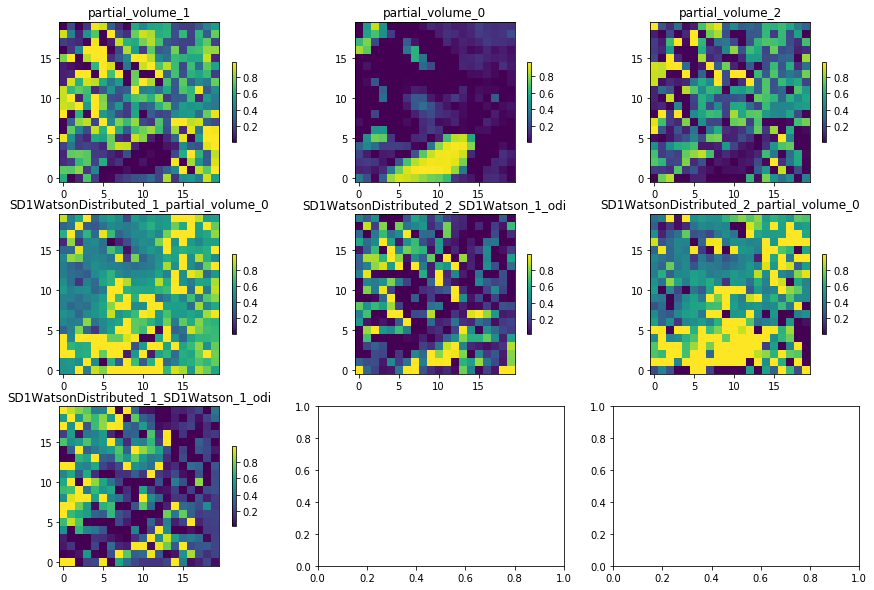

In [18]:
fitted_parameters = NODDIx_fit.fitted_parameters

fig, axs = plt.subplots(3, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

While MIX still produced in good FOD fields, this means that in its current form MIX lacks a way to automatically select the best (actual) number of bundles in a voxel. This means model parameters do not have a microstructural interpretation when the number of defined bundles does not match the actual number of bundles. A sparsity regularization on the volume fractions such as used by *(Zhu et al. 2013)* could be solution.

## References
- Farooq, Hamza, et al. "Microstructure imaging of crossing (MIX) white matter fibers from diffusion MRI." Scientific reports 6 (2016): 38927.
- Zhang, Hui, et al. "NODDI: practical in vivo neurite orientation dispersion and density imaging of the human brain." Neuroimage 61.4 (2012): 1000-1016.
- Zhu, Xinghua, et al. "Model selection and estimation of multi-compartment models in diffusion mri with a rician noise model." International Conference on Information Processing in Medical Imaging. Springer, Berlin, Heidelberg, 2013.